In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [2]:
#brew install graphviz
#!pip install torchviz

In [3]:
'''# Example dataset dimensions
num_time_steps = 1000     # Number of time steps
num_altitudes = 50        # Number of altitude levels
num_latitudes = 200       # Latitude grid size
num_longitudes = 200      # Longitude grid size
# Create a synthetic dataset (replace with actual data)
reflectivity_grid = np.random.rand(num_time_steps, num_altitudes, num_latitudes, num_longitudes).astype(np.float32)
rainfall_grid = np.random.rand(num_time_steps, num_latitudes, num_longitudes).astype(np.float32)'''

'# Example dataset dimensions\nnum_time_steps = 1000     # Number of time steps\nnum_altitudes = 50        # Number of altitude levels\nnum_latitudes = 200       # Latitude grid size\nnum_longitudes = 200      # Longitude grid size\n# Create a synthetic dataset (replace with actual data)\nreflectivity_grid = np.random.rand(num_time_steps, num_altitudes, num_latitudes, num_longitudes).astype(np.float32)\nrainfall_grid = np.random.rand(num_time_steps, num_latitudes, num_longitudes).astype(np.float32)'

In [4]:
radar_ros = np.load('radar_data_ros_reduced.npy', allow_pickle=True)
rain_ros = np.load('rain_data_ros.npy', allow_pickle=True)


In [7]:
num_time_steps = 3        # Number of time steps (3 in radar_ros)
num_latitudes = 2815      # Latitude/longitude grid size
#num_altitudes = 40  

In [8]:
X = torch.tensor(radar_ros,dtype=torch.float32).unsqueeze(1)   # Shape: (channels, time_steps, altitudes)
y = torch.tensor(rain_ros,dtype=torch.float32)   # Shape: (channels, time_steps)
# Create TensorDataset and DataLoader
# Create TensorDataset and DataLoader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [9]:
'''# Multi-GPU support (if available)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_model = nn.DataParallel(cnn_model)'''

'# Multi-GPU support (if available)\nif torch.cuda.device_count() > 1:\n    print(f"Using {torch.cuda.device_count()} GPUs")\n    cnn_model = nn.DataParallel(cnn_model)'

In [26]:
# CNN-LSTM model in PyTorch (Adjusted to prevent size issues)
class CNNLSTMModel(nn.Module):
    def __init__(self, num_latitudes, num_time_steps):
        super(CNNLSTMModel, self).__init__()
        
        # Convolutional layers
        self.conv2d_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
        self.pool2d_1 = nn.MaxPool2d(kernel_size=(1, 2))  # Keep latitude dimension larger

        self.conv2d_2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool2d_2 = nn.MaxPool2d(kernel_size=(1, 2))  # Keep latitude dimension larger

        self.conv2d_3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
        self.pool2d_3 = nn.MaxPool2d(kernel_size=(1, 2))  # Keep latitude dimension larger

        # LSTM input size
        self.flatten_size = (num_latitudes // 8) * 128  # Adjust based on pooling layers
        
        # LSTM layer for temporal sequence
        self.lstm = nn.LSTM(input_size=self.flatten_size, hidden_size=512, batch_first=True)
        self.fc = nn.Linear(512, num_latitudes)
    
    def forward(self, x):
        batch_size, time_steps = x.shape[:2]

        # Reshape input for Conv2D
        x = x.view(-1, 1, *x.shape[2:])  # Merge batch and time dimension, add channel dim
        
        # Apply Conv2D + MaxPool2D layers
        x = self.pool2d_1(torch.relu(self.conv2d_1(x)))
        #print(f"Shape after Conv2D 1: {x.shape}")  # Debugging line

        x = self.pool2d_2(torch.relu(self.conv2d_2(x)))
        #print(f"Shape after Conv2D 2: {x.shape}")  # Debugging line

        x = self.pool2d_3(torch.relu(self.conv2d_3(x)))
        #print(f"Shape after Conv2D 3: {x.shape}")  # Debugging line

        # Check the shape of x before flattening
        if x.shape[2] == 0:  # Check if width is zero
            raise ValueError("Width of the output is zero, check pooling and convolution parameters.")

        # Flatten and reshape back to (batch_size, time_steps, features)
        x = x.view(batch_size, time_steps, -1)
        
        # LSTM layer
        x, _ = self.lstm(x)
        
        # Fully connected layer and reshape to (latitudes)
        x = torch.relu(self.fc(x[:, -1, :]))  # Use the last LSTM output for prediction
        return x


# Model initialization
input_shape = (num_time_steps, num_latitudes)  # No altitudes anymore
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = CNNLSTMModel(num_latitudes, num_time_steps).to(device)

# Optimizer and loss function
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# RMSE loss function
def rmse_loss(outputs, targets):
    return torch.sqrt(torch.mean((outputs - targets) ** 2))

import matplotlib.pyplot as plt

# Training Loop
def train_model(model, train_loader, optimizer, loss_fn, device, epochs=10):
    model.train()
    train_losses = []  # Store training losses
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = rmse_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)  # Append epoch loss
        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {epoch_loss:.4f}")
    return train_losses  # Return training losses

# Testing Loop
def test_model(model, test_loader, loss_fn, device, epochs=10):
    model.eval()
    test_losses = []  # Store testing losses
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = rmse_loss(outputs, targets)
            test_loss += loss.item()
    average_test_loss = test_loss / len(test_loader)
    test_losses.append(average_test_loss)  # Append test loss
    print(f"Test Loss: {average_test_loss:.4f}")
    return test_losses  # Return testing losses



# Train and test the model
#train_model(cnn_model, train_loader, optimizer, loss_fn, device, epochs=10)

In [40]:
#test_model(cnn_model, test_loader, loss_fn, device)


Test Loss: 472.7301


Shape after Conv2D 1: torch.Size([32, 1, 1407])
Shape after Conv2D 2: torch.Size([64, 1, 703])
Shape after Conv2D 3: torch.Size([128, 1, 351])
Shape after Conv2D 1: torch.Size([32, 1, 1407])
Shape after Conv2D 2: torch.Size([64, 1, 703])
Shape after Conv2D 3: torch.Size([128, 1, 351])
Shape after Conv2D 1: torch.Size([32, 1, 1407])
Shape after Conv2D 2: torch.Size([64, 1, 703])
Shape after Conv2D 3: torch.Size([128, 1, 351])
Epoch [1/20] Loss: 12.6414
Shape after Conv2D 1: torch.Size([32, 1, 1407])
Shape after Conv2D 2: torch.Size([64, 1, 703])
Shape after Conv2D 3: torch.Size([128, 1, 351])
Shape after Conv2D 1: torch.Size([32, 1, 1407])
Shape after Conv2D 2: torch.Size([64, 1, 703])
Shape after Conv2D 3: torch.Size([128, 1, 351])
Shape after Conv2D 1: torch.Size([32, 1, 1407])
Shape after Conv2D 2: torch.Size([64, 1, 703])
Shape after Conv2D 3: torch.Size([128, 1, 351])
Epoch [2/20] Loss: 12.6416
Shape after Conv2D 1: torch.Size([32, 1, 1407])
Shape after Conv2D 2: torch.Size([64, 1,

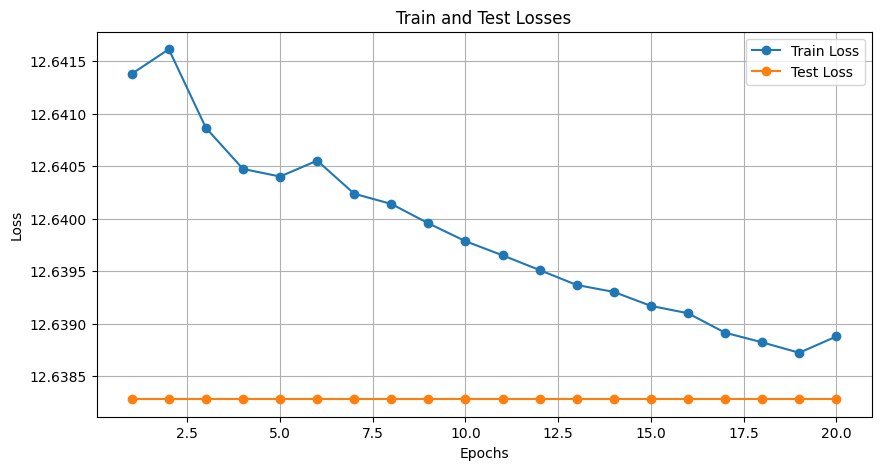

In [24]:
# Train and test the model
train_losses = train_model(cnn_model, train_loader, optimizer, rmse_loss, device, epochs=20)
test_losses = test_model(cnn_model, test_loader, rmse_loss, device,epochs=20)

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, test_losses * len(train_losses), label='Test Loss', marker='o')  # Repeat test loss for plotting
plt.title('Train and Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Epoch [1/10] - Train Loss (RMSE): 12.6915, Test Loss (RMSE): 12.6613
Epoch [2/10] - Train Loss (RMSE): 12.6611, Test Loss (RMSE): 12.6544
Epoch [3/10] - Train Loss (RMSE): 12.6562, Test Loss (RMSE): 12.6520
Epoch [4/10] - Train Loss (RMSE): 12.6530, Test Loss (RMSE): 12.6506
Epoch [5/10] - Train Loss (RMSE): 12.6509, Test Loss (RMSE): 12.6484
Epoch [6/10] - Train Loss (RMSE): 12.6485, Test Loss (RMSE): 12.6467
Epoch [7/10] - Train Loss (RMSE): 12.6469, Test Loss (RMSE): 12.6447
Epoch [8/10] - Train Loss (RMSE): 12.6447, Test Loss (RMSE): 12.6419
Epoch [9/10] - Train Loss (RMSE): 12.6420, Test Loss (RMSE): 12.6400
Epoch [10/10] - Train Loss (RMSE): 12.6400, Test Loss (RMSE): 12.6385


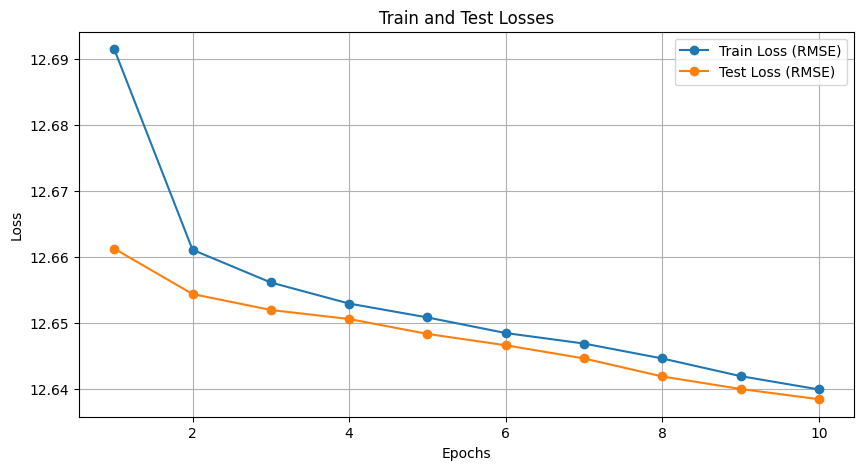

In [27]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Training and Testing Loop (Updated for new dimensions)
def train_and_test_model(model, train_loader, test_loader, optimizer, device, epochs=10):
    model.train()
    all_train_losses = []  # Store training losses
    all_test_losses = []   # Store testing losses

    for epoch in range(epochs):
        running_train_loss = 0.0
        # Training phase
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = rmse_loss(outputs, targets)  # RMSE loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimization step
            running_train_loss += loss.item()

        # Calculate average train loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        all_train_losses.append(avg_train_loss)

        # Testing phase
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)  # Forward pass (testing)
                loss = rmse_loss(outputs, targets)  # RMSE loss
                running_test_loss += loss.item()

        # Calculate average test loss for the epoch
        avg_test_loss = running_test_loss / len(test_loader)
        all_test_losses.append(avg_test_loss)

        # Print training and testing losses for the current epoch
        print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss (RMSE): {avg_train_loss:.4f}, Test Loss (RMSE): {avg_test_loss:.4f}")

    return all_train_losses, all_test_losses  # Return training and testing losses

# Train and test the model
train_losses, test_losses = train_and_test_model(cnn_model, train_loader, test_loader, optimizer, device, epochs=10)

# Plotting the losses
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss (RMSE)', marker='o')
plt.plot(epochs_range, test_losses, label='Test Loss (RMSE)', marker='o')
plt.title('Train and Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

